# import library

In [1]:
import os
import time
import numpy as np
import tifffile as tiff
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (Input, Concatenate, Conv2D, LeakyReLU, 
                                     BatchNormalization, Conv2DTranspose, Activation, 
                                     Dropout, Add, UpSampling2D, ZeroPadding2D)
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from skimage import exposure
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [2]:
# ReflectionPadding2D 레이어
class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        padding_width, padding_height = self.padding
        return tf.pad(x, 
                      [[0, 0], [padding_height, padding_height], [padding_width, padding_width], [0, 0]], 
                      'REFLECT')


In [3]:
# Directories for results and logs
current_time = time.strftime("%m%d_%H%M")
result_dir = os.path.join(os.getcwd(), 'result', f'logs_8x8_{current_time}')
os.makedirs(result_dir, exist_ok=True)
log_dir = os.path.join(os.getcwd(), 'logs', f'logs_8x8_{current_time}')
os.makedirs(log_dir, exist_ok=True)

print(f'Result directory created: {result_dir}')
print(f'Log directory created: {log_dir}')

# Training parameters
Epoch = 500
batch = 32

Result directory created: /jsm0707/GAN/result/logs_8x8_0807_1154
Log directory created: /jsm0707/GAN/logs/logs_8x8_0807_1154


# Data load

(864, 256, 256) (864, 256, 256)


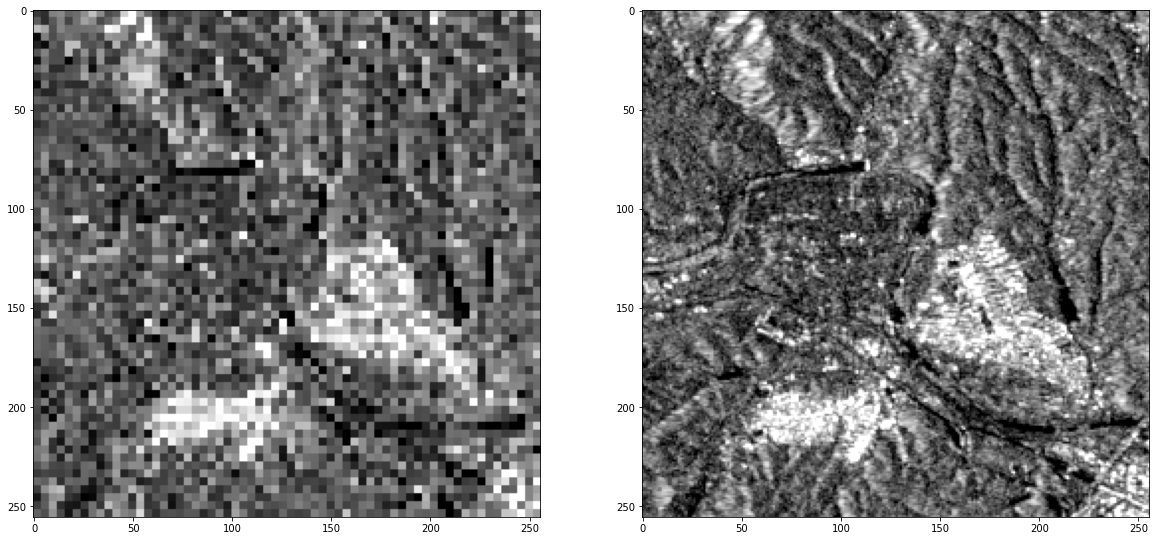

In [4]:

# Function to load TIFF files
def load_tif_files(directory, target_size=(256, 256)):
    files = sorted([os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.tif')])
    data = []
    for file in files:
        img = tiff.imread(file)
        img_resized = cv2.resize(img, target_size)
        data.append(img_resized)
    return np.array(data)

def load_dataset(x_directory, y_directory):
    x_data = load_tif_files(x_directory)
    y_data = load_tif_files(y_directory)
    return x_data, y_data

# Function to adjust contrast
def contrast(image): 
    valid_data = image[np.logical_and(image != np.inf, image != -np.inf)] 
    in_low, in_high = np.percentile(valid_data, (2, 98))
    image = exposure.rescale_intensity(image, in_range=(in_low, in_high))
    return image

# Load data
x_directory = os.path.join(os.getcwd(), 'test_image', 'subset_512_8x8')
y_directory = os.path.join(os.getcwd(), 'test_image', 'subset_512')
X, y = load_dataset(x_directory, y_directory)
print(X.shape, y.shape)

# Plot sample images
fig, axs = plt.subplots(1, 2, figsize=(20, 15))
axs[0].imshow(contrast(X[0]), cmap='gray')
axs[1].imshow(contrast(y[0]), cmap='gray')
plt.show()

# Define Discriminator

In [5]:
# Function to load a batch of data
def load_data(batch_size):
    i = np.random.randint(0, int(len(X) / batch_size))
    img_A = (np.array(X[i:i + batch_size]) / 5000.0) - 1
    img_B = (np.array(y[i:i + batch_size]) / 5000.0) - 1
    return img_A, img_B

# Generator to load batches of data
def load_batch(batch_size):
    for i in range(int(len(X) / batch_size)):
        img_A = (X[i:i + batch_size] / 5000.0) - 1
        img_B = (y[i:i + batch_size] / 5000.0) - 1
        yield img_A, img_B

In [6]:
# Function to define the discriminator model
def define_discriminator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_src_image = Input(shape=image_shape)
    in_target_image = Input(shape=image_shape)
    merged = Concatenate()([in_src_image, in_target_image])
    d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    d = Conv2D(512, (4, 4), padding='same', kernel_initializer=init)(d)
    d = BatchNormalization()(d)
    d = LeakyReLU(alpha=0.2)(d)
    patch_out = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
    patch_out = Activation('sigmoid')(patch_out)
    model = Model([in_src_image, in_target_image], patch_out)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
    return model

# Define Generator

In [7]:
# Function to define the encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True, padding='reflect'):
    init = RandomNormal(stddev=0.02)
    if padding == 'reflect':
        layer_in = ReflectionPadding2D((1, 1))(layer_in)
    g = Conv2D(n_filters, (4, 4), strides=(2, 2), padding='same' if padding != 'reflect' else 'valid', kernel_initializer=init)(layer_in)
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    g = LeakyReLU(alpha=0.2)(g)
    return g

# Function to define the decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(n_filters, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    if dropout:
        g = Dropout(0.5)(g, training=True)
    
    # Adjust skip_in dimensions to match g dimensions
    g_shape = K.int_shape(g)
    skip_in_shape = K.int_shape(skip_in)
    if g_shape[1] != skip_in_shape[1] or g_shape[2] != skip_in_shape[2]:
        skip_in = UpSampling2D(size=(g_shape[1] // skip_in_shape[1], g_shape[2] // skip_in_shape[2]))(skip_in)
    
    g = Concatenate()([g, skip_in])
    g = Activation('relu')(g)
    return g

# Function to define the residual block
def residual_block(layer_in, n_filters, kernel_size=(3,3)):
    init = RandomNormal(stddev=0.02)
    g = Conv2D(n_filters, kernel_size, padding='same', kernel_initializer=init)(layer_in)
    g = BatchNormalization()(g, training=True)
    g = Activation('relu')(g)
    g = Conv2D(n_filters, kernel_size, padding='same', kernel_initializer=init)(g)
    g = BatchNormalization()(g, training=True)
    g = Add()([g, layer_in])
    return g

# Function to define the generator model
def define_generator(image_shape):
    init = RandomNormal(stddev=0.02)
    in_image = Input(shape=image_shape)
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    b = Conv2D(512, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # Adding Residual Blocks
    r1 = residual_block(b, 512)
    r2 = residual_block(r1, 512)
    r3 = residual_block(r2, 512)
    d1 = decoder_block(r3, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    g = Conv2DTranspose(image_shape[-1], (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(d7)
    out_image = Activation('tanh')(g)
    model = Model(in_image, out_image)
    return model

# Define Gan

In [8]:

# Function to define the GAN model
def define_gan(g_model, d_model, image_shape):
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    in_src = Input(shape=image_shape)
    gen_out = g_model(in_src)
    dis_out = d_model([in_src, gen_out])
    model = Model(in_src, [dis_out, gen_out])
    opt = Adam(learning_rate=0.0001, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
    return model

# Function to generate real samples
def generate_real_samples(n_samples, patch_shape):
    trainA, trainB = load_data(n_samples)
    ix = np.random.randint(0, trainA.shape[0], n_samples)
    X1, X2 = trainA[ix], trainB[ix]
    y = np.ones((n_samples, patch_shape, patch_shape, 1)) * 0.9  # 라벨 스무딩 적용
    return [X1, X2], y

# Function to generate fake samples
def generate_fake_samples(g_model, samples, patch_shape):
    X = g_model.predict(samples)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

In [9]:
# Function to summarize performance
def summarize_performance(step, g_model, result_dir, n_samples):
    r, c = 3, n_samples
    [X_realA, X_realB], _ = generate_real_samples(n_samples, 1)
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    gen_imgs = [X_realA, X_fakeB, X_realB]
    titles = ['Condition', 'Generated', 'Original']
    fig, axs = plt.subplots(r, c, figsize=(20, 20))
    for i in range(r):
        for j in range(c):
            image = gen_imgs[i][j]
            rescaled_image = (image + 1) * 5000
            axs[i, j].imshow(contrast(rescaled_image / 10000), cmap='gray')
            axs[i, j].set_title(titles[i])
            axs[i, j].axis('off')
    filename = '%s/plot_%06d.png' % (result_dir, step)
    fig.savefig(filename)

# Training

In [11]:
def adjust_learning_rate(optimizer, epoch, factor=0.5, patience=5, min_lr=1e-7, verbose=1):
    if epoch > 0 and epoch % patience == 0:
        lr = K.get_value(optimizer.lr)
        new_lr = max(lr * factor, min_lr)
        if lr != new_lr:
            K.set_value(optimizer.lr, new_lr)
            if verbose:
                print(f'Epoch {epoch}: ReduceLROnPlateau reducing learning rate to {new_lr}.')

In [13]:
# TensorBoard and learning rate reduction callback
tensorboard_callback = TensorBoard(log_dir=log_dir)
file_writer = tf.summary.create_file_writer(log_dir)
reduce_lr = ReduceLROnPlateau(monitor='G_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)

def train(d_model, g_model, gan_model, n_epochs, n_batch, result_dir, d_filename, g_filename, file_writer, update_ratio=5, lr_patience=5, lr_factor=0.5, min_lr=1e-7):
    n_patch = d_model.output_shape[1]
    for epoch in range(1, n_epochs + 1):
        for batch_i, (trainA, trainB) in enumerate(load_batch(n_batch)):
            [X_realA, X_realB], y_real = generate_real_samples(n_batch, n_patch)
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            # Update discriminator more frequently
            if batch_i % update_ratio == 0:
                d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
                d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
                with file_writer.as_default():
                    tf.summary.scalar('D1_loss', d_loss1, step=epoch)
                    tf.summary.scalar('D2_loss', d_loss2, step=epoch)
            
            # Always update generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
            with file_writer.as_default():
                tf.summary.scalar('G_loss', g_loss, step=epoch)

        summarize_performance(epoch, g_model, result_dir, n_samples=3)
        print('[Epoch %d] D1_loss: %.3f, D2_loss: %.3f, G_loss: %.3f' % (epoch, d_loss1, d_loss2, g_loss))
        
        # Adjust learning rate if necessary
        adjust_learning_rate(gan_model.optimizer, epoch, factor=lr_factor, patience=lr_patience, min_lr=min_lr)
        
        g_model.save(g_filename)
        d_model.save(d_filename)


# Model setup and training
image_shape = (X.shape[1], X.shape[2], 1)
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
g_filename = os.path.join(result_dir, 'g_model.h5')
d_filename = os.path.join(result_dir, 'd_model.h5')

# Load pre-trained models if available
if os.path.exists(g_filename):
    g_model.load_weights(g_filename)
if os.path.exists(d_filename):
    d_model.load_weights(d_filename)

gan_model = define_gan(g_model, d_model, image_shape)
train(d_model, g_model, gan_model, n_epochs=Epoch, n_batch=batch, result_dir=result_dir, d_filename=d_filename, g_filename=g_filename, file_writer=file_writer)

ERROR:tensorflow:Failed to start profiler: Another profiler is running.


TypeError: train() got an unexpected keyword argument 'reduce_lr'

# inference코드

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage import exposure
import cv2
import tifffile as tiff

def load_tif_file(file_path, target_size=(256, 256)):
    img = tiff.imread(file_path)
    img_resized = cv2.resize(img, target_size)
    return np.array(img_resized)

def contrast(image):
    valid_data = image[np.logical_and(image != np.inf, image != -np.inf)]
    in_low, in_high = np.percentile(valid_data, (2, 98))
    image = exposure.rescale_intensity(image, in_range=(in_low, in_high))
    return image

def visualize_results(X_realA, X_fakeB, save_path=None):
    gen_imgs = [X_realA, X_fakeB]
    titles = ['Condition', 'Generated']
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    for i in range(2):
        image = gen_imgs[i]
        rescaled_image = (image + 1) * 5000
        axs[i].imshow(contrast(rescaled_image / 10000), cmap='gray')
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    if save_path:
        fig.savefig(save_path)
    plt.show()

def perform_inference(g_model, file_path, save_path=None):
    X_realA = load_tif_file(file_path)

    X_realA = (X_realA / 5000.0) - 1

    # Ensure the input shape matches the expected shape of the model
    if len(X_realA.shape) == 2:  # Add channel dimension if missing
        X_realA = np.expand_dims(X_realA, axis=-1)
    
    # Ensure that input is 4-dimensional (batch, height, width, channels)
    X_realA = np.expand_dims(X_realA, axis=0)

    X_fakeB = g_model.predict(X_realA)

    # Ensure the output is squeezed to remove the batch dimension
    X_fakeB = np.squeeze(X_fakeB, axis=0)
    X_realA = np.squeeze(X_realA, axis=0)

    visualize_results(X_realA, X_fakeB, save_path)

In [ ]:
# File path
file_path = os.path.join(os.getcwd(), 'test_image', 'subset_512_4x4', 'S1A_IW_GRDH_1SDV_20210105T092315_20210105T092344_036001_0437B7_42D51_subset_0_0.tif')

# Load the saved generator model
result_dir = os.path.join(os.getcwd(), 'result', 'logs_8x8_0709_1551_code1')
g_model_path = os.path.join(result_dir, 'd_model.h5')

if not os.path.exists(g_model_path):
    raise FileNotFoundError(f"Generator model not found at {g_model_path}")

# Load the generator model
g_model = load_model(g_model_path, compile=False)
print("Generator model loaded successfully.")

# Perform inference
output_image_path = os.path.join(result_dir, 'inference_result.png')
perform_inference(g_model, file_path, save_path=output_image_path)